## Work
1. 請比較使用不同層數以及不同 Dropout rate 對訓練的效果
2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

In [1]:
import os
import keras
import itertools

import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import Dropout

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [10]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 256
Dropout_EXP = [0.1, 0.2, 0.3]
num_neurons=[1024, 512, 256, 128, 128, 128, 64]

In [11]:
results={}
"""
撰寫訓練流程並將結果用 dictionary 紀錄
"""
for i in range(3):
    num_layers= len(num_neurons)-i*2
    neurons = num_neurons[:num_layers]
    
    for dr in Dropout_EXP:        
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with %d layers and DR = %.6f" % (num_layers, dr))
        model = build_mlp(input_shape=x_train.shape[1:], num_neurons=neurons, drp_ratio=dr)
        model.summary()
        optimizer = keras.optimizers.Adam(lr=LEARNING_RATE, epsilon=None, decay=0.0)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)         

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]

        exp_name_tag = "exp-%slayers-dr-%s" % (str(num_layers), str(dr))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

Experiment with 7 layers and DR = 0.100000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 1024)              3146752   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropo

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 88us/step - loss: 2.2155 - accuracy: 0.1449 - val_loss: 2.0553 - val_accuracy: 0.1900
Epoch 2/25
50000/50000 [==============================] - 3s 68us/step - loss: 2.0363 - accuracy: 0.2114 - val_loss: 1.9094 - val_accuracy: 0.2808
Epoch 3/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.9271 - accuracy: 0.2690 - val_loss: 1.8265 - val_accuracy: 0.3141
Epoch 4/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.8693 - accuracy: 0.2986 - val_loss: 1.7687 - val_accuracy: 0.3472
Epoch 5/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.8299 - accuracy: 0.3166 - val_loss: 1.7237 - val_accuracy: 0.3687
Epoch 6/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.7840 - accuracy: 0.3395 - val_loss: 1.7012 - val_accuracy: 0.3844
Epoch 7/25
50000/50000 [==============================] - 3s 67us/st

Epoch 14/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.8199 - accuracy: 0.3164 - val_loss: 1.7829 - val_accuracy: 0.3566
Epoch 15/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.8084 - accuracy: 0.3250 - val_loss: 1.7409 - val_accuracy: 0.3639
Epoch 16/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.8002 - accuracy: 0.3321 - val_loss: 1.7819 - val_accuracy: 0.3680
Epoch 17/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.7891 - accuracy: 0.3391 - val_loss: 1.7578 - val_accuracy: 0.3702
Epoch 18/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.7768 - accuracy: 0.3437 - val_loss: 1.7025 - val_accuracy: 0.3922
Epoch 19/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.7610 - accuracy: 0.3549 - val_loss: 1.7154 - val_accuracy: 0.3982
Epoch 20/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.7533 - accuracy: 0.3547 - val_

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 61us/step - loss: 2.1314 - accuracy: 0.1890 - val_loss: 1.9275 - val_accuracy: 0.2865
Epoch 2/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.9074 - accuracy: 0.2975 - val_loss: 1.8214 - val_accuracy: 0.3481
Epoch 3/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.8301 - accuracy: 0.3345 - val_loss: 1.7268 - val_accuracy: 0.3745
Epoch 4/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.7718 - accuracy: 0.3587 - val_loss: 1.6672 - val_accuracy: 0.4062
Epoch 5/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.7277 - accuracy: 0.3821 - val_loss: 1.6322 - val_accuracy: 0.4140
Epoch 6/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.6895 - accuracy: 0.3946 - val_loss: 1.6100 - val_accuracy: 0.4235
Epoch 7/25
50000/50000 [==============================] - 3s 59us/st

50000/50000 [==============================] - 3s 63us/step - loss: 1.6593 - accuracy: 0.4028 - val_loss: 1.6006 - val_accuracy: 0.4374
Epoch 18/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.6479 - accuracy: 0.4049 - val_loss: 1.5849 - val_accuracy: 0.4456
Epoch 19/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.6447 - accuracy: 0.4070 - val_loss: 1.5768 - val_accuracy: 0.4526
Epoch 20/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.6365 - accuracy: 0.4113 - val_loss: 1.5878 - val_accuracy: 0.4431
Epoch 21/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.6313 - accuracy: 0.4129 - val_loss: 1.5811 - val_accuracy: 0.4418
Epoch 22/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.6184 - accuracy: 0.4185 - val_loss: 1.5716 - val_accuracy: 0.4484
Epoch 23/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.6136 - accuracy: 0.4195 - val_loss: 1.5547

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 60us/step - loss: 2.0611 - accuracy: 0.2486 - val_loss: 1.7977 - val_accuracy: 0.3471
Epoch 2/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.8046 - accuracy: 0.3478 - val_loss: 1.6950 - val_accuracy: 0.3968
Epoch 3/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.7389 - accuracy: 0.3773 - val_loss: 1.6449 - val_accuracy: 0.4099
Epoch 4/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.6836 - accuracy: 0.3990 - val_loss: 1.6039 - val_accuracy: 0.4331
Epoch 5/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.6493 - accuracy: 0.4140 - val_loss: 1.5714 - val_accuracy: 0.4356
Epoch 6/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.6105 - accuracy: 0.4249 - val_loss: 1.5387 - val_accuracy: 0.4484
Epoch 7/25
50000/50000 [==============================] - 3s 56us/st

50000/50000 [==============================] - 3s 57us/step - loss: 1.5168 - accuracy: 0.4536 - val_loss: 1.4560 - val_accuracy: 0.4935
Epoch 19/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.5088 - accuracy: 0.4598 - val_loss: 1.4674 - val_accuracy: 0.4806
Epoch 20/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.5023 - accuracy: 0.4595 - val_loss: 1.4483 - val_accuracy: 0.4900
Epoch 21/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.4925 - accuracy: 0.4622 - val_loss: 1.4391 - val_accuracy: 0.4987
Epoch 22/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.4829 - accuracy: 0.4671 - val_loss: 1.4539 - val_accuracy: 0.4932
Epoch 23/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.4833 - accuracy: 0.4668 - val_loss: 1.4442 - val_accuracy: 0.4888
Epoch 24/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.4759 - accuracy: 0.4695 - val_loss: 1.4416

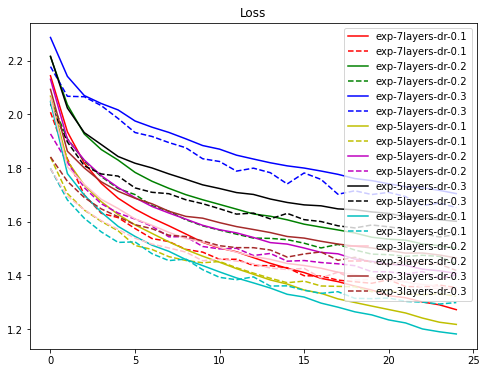

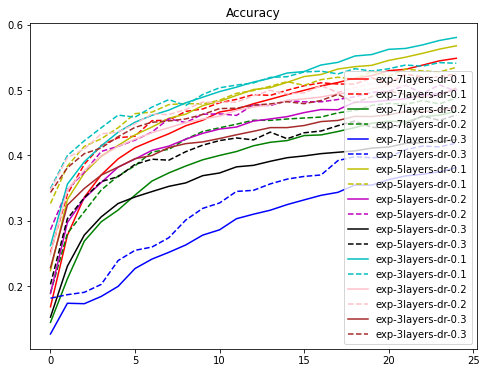

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k", "c", "pink", "brown"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()
